In [6]:
#!pipenv install --skip-lock pmdarima
#!pipenv install --skip-lock matplotlib
#!pipenv install --skip-lock nb-black

In [4]:
# check pmdarima
from pmdarima.arima import auto_arima

### ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

In [5]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import datetime

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [6]:
df = pd.read_csv("./clean_data/integrated_candlesticks3600.csv")
# datetime index
# df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
# df["Datetime"] = pd.to_datetime(df["New_ID"])

base = datetime.datetime.today()
date_list = [base + datetime.timedelta(days=x) for x in range(len(df))]
df.insert(0, "New_ID", date_list)  # fake date

df = df.set_index("New_ID")

<IPython.core.display.Javascript object>

In [7]:
df.head(5)

,Date,Time,Open,High,Low,Close
New_ID,,,,,,
2022-02-22 22:15:46.984889,2022-01-04,09:00,203,218,179,207
2022-02-23 22:15:46.984889,2022-01-04,10:00,217,221,186,189
2022-02-24 22:15:46.984889,2022-01-04,11:00,189,228,189,227
2022-02-25 22:15:46.984889,2022-01-04,12:00,227,228,194,225
2022-02-26 22:15:46.984889,2022-01-04,13:00,225,231,195,224


<IPython.core.display.Javascript object>

In [112]:
df = df[["Close"]].copy()

<IPython.core.display.Javascript object>

In [113]:
df.describe()

,Close
count,387.000000
mean,212.085271
std,28.745812
min,154.000000
25%,192.000000
50%,207.000000
75%,230.500000
max,304.000000


<IPython.core.display.Javascript object>

An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR term

- d is the number of differencing required to make the time series stationary

- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.



### Stationarity

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times. 

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model. 

#### ADF test

We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [114]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.6221562636216573
p-value: 0.08850393204346685


<IPython.core.display.Javascript object>

#### Autocorrelation Function (ACF)

In [115]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

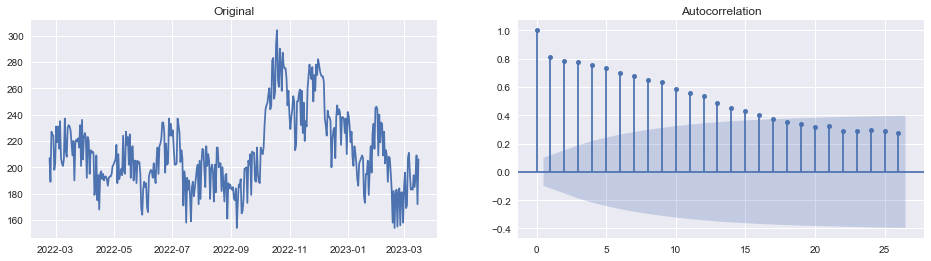

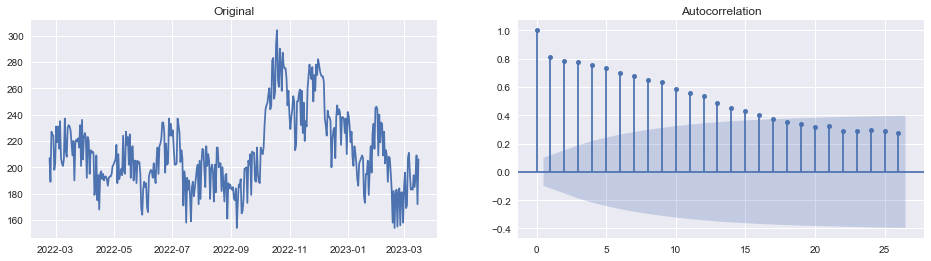

<IPython.core.display.Javascript object>

In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Close, ax=ax2)

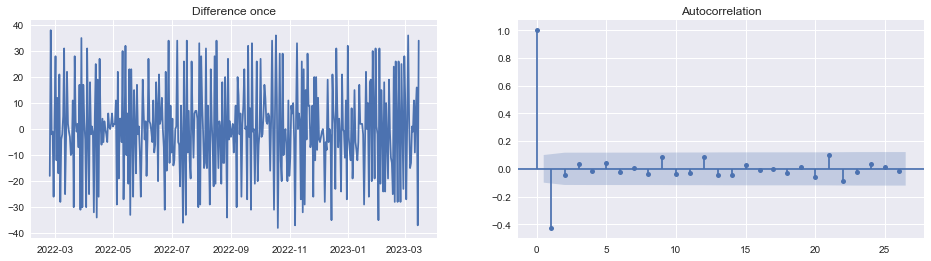

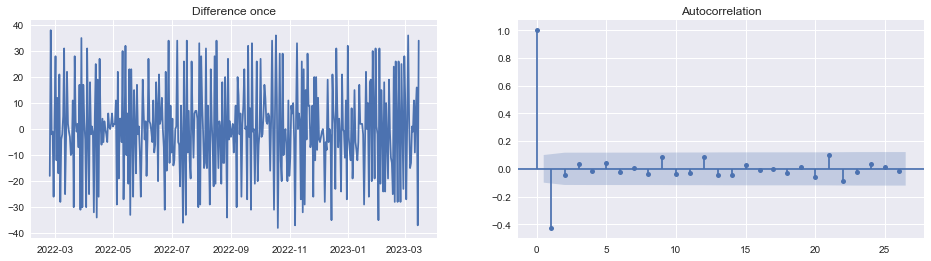

<IPython.core.display.Javascript object>

In [117]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)

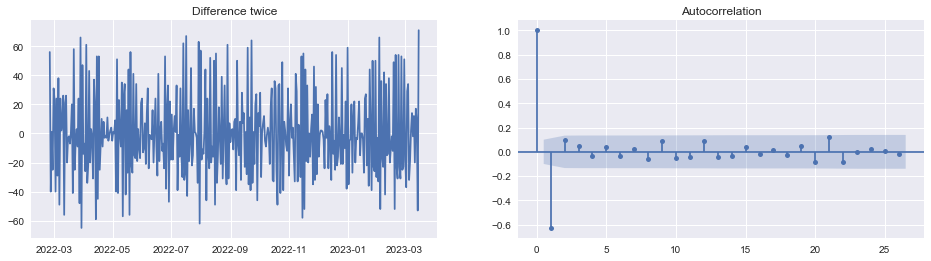

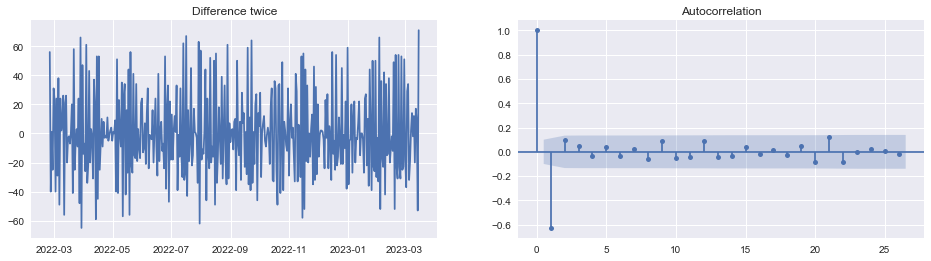

<IPython.core.display.Javascript object>

In [118]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2)

We can use the pmdarima package to get the number of differencing.

In [119]:
#!pipenv install --skip-lock pmdarima

from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

In [120]:
ndiffs(df.Close, test="adf")

1

<IPython.core.display.Javascript object>

#### p

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags. 

In [121]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

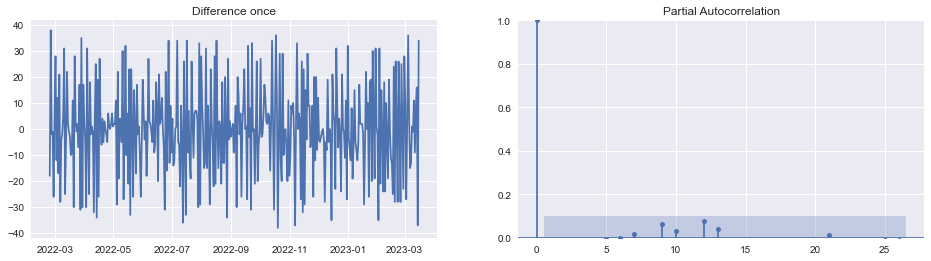

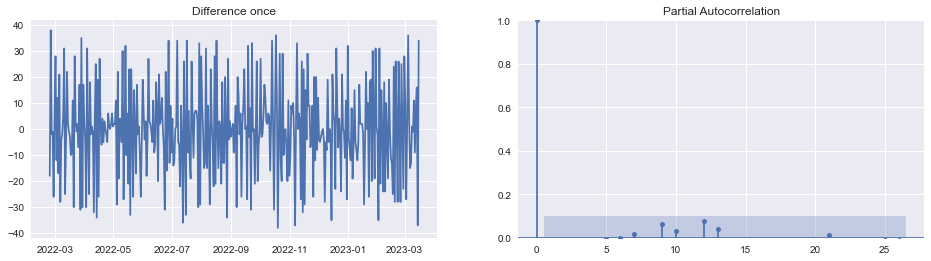

<IPython.core.display.Javascript object>

In [122]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)

We can observe that the PACF lag 6 is significant as it's above the significance line.

#### q

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.

,Close
New_ID,
2022-02-22 15:17:13.211844,207
2022-02-23 15:17:13.211844,189
2022-02-24 15:17:13.211844,227
2022-02-25 15:17:13.211844,225
2022-02-26 15:17:13.211844,224


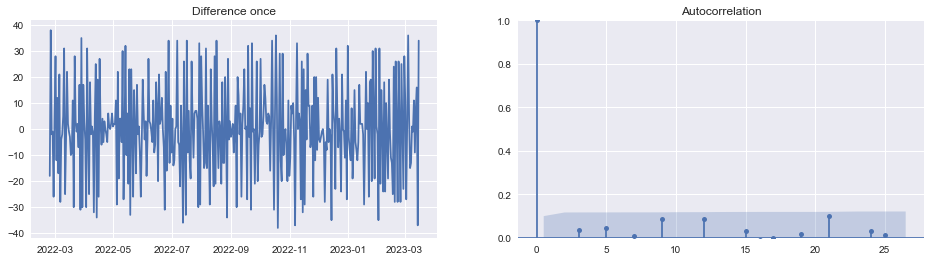

<IPython.core.display.Javascript object>

In [123]:
diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)
df = df[["Close"]]
df.head(5)

In [130]:
from chart_studio.plotly import plot_mpl
from plotly.offline import iplot
from statsmodels.tsa.seasonal import seasonal_decompose

df = df[["Close"]]
result = seasonal_decompose(df, model="multiplicative")
print(result["Trend"])
# fig = result.plot()
# plot_mpl(fig)

TypeError: 'DecomposeResult' object is not subscriptable

<IPython.core.display.Javascript object>

#### Fitting the ARIMA model

In [87]:
import statsmodels.api as sm

# # ARIMA Model
# model = sm.tsa.arima.ARIMA(df.close, order=(6, 1, 3))
# result = model.fit()
# print(result.summary())

mod = sm.tsa.statespace.SARIMAX(df.Close, trend="c", order=(0, 1, 1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  387
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1593.763
Date:                Tue, 22 Feb 2022   AIC                           3193.525
Time:                        01:08:34   BIC                           3205.393
Sample:                             0   HQIC                          3198.232
                                - 387                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0346      0.319     -0.108      0.914      -0.660       0.591
ma.L1         -0.5954      0.042    -14.243      0.000      -0.677      -0.513
sigma2       225.6139     19.020     11.862      0.0

<IPython.core.display.Javascript object>

(array([0.00761394, 0.0208601 , 0.01178596, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0001043 ]),
 array([-40.7091314 , -15.9347594 ,   8.83961261,  33.61398462,
         58.38835662,  83.16272863, 107.93710063, 132.71147264,
        157.48584464, 182.26021665, 207.03458865]),
 <BarContainer object of 10 artists>)

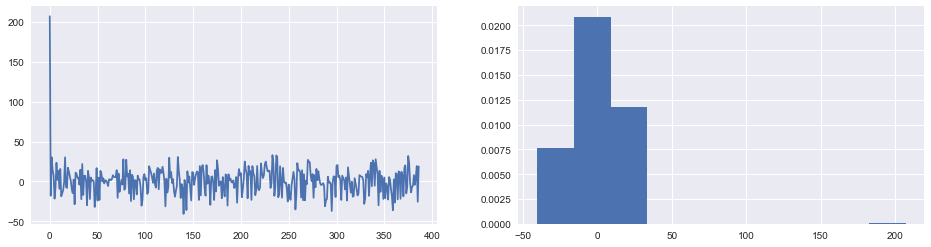

<IPython.core.display.Javascript object>

In [88]:
# Plot residual errors
residuals = pd.DataFrame(res.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)


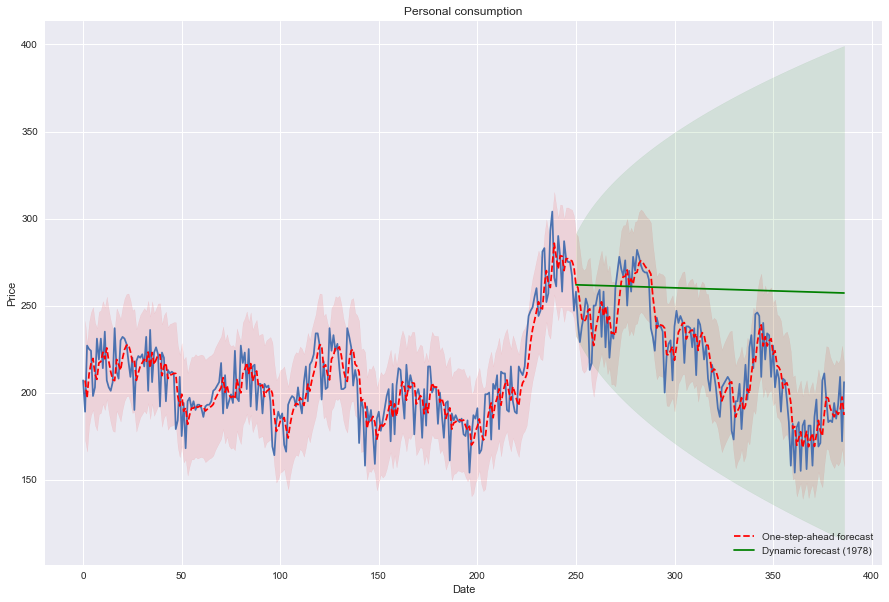

<IPython.core.display.Javascript object>

In [89]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
# Dynamic predictions
predict_dy = res.get_prediction(dynamic=250)
predict_dy_ci = predict_dy.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(15,10))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Price')

# Plot data points
plt.plot(df.Close)
# plt.plot(predict.predicted_mean)
# Plot predictions
predict.predicted_mean.loc[1:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc[1:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc[250:].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc[250:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')


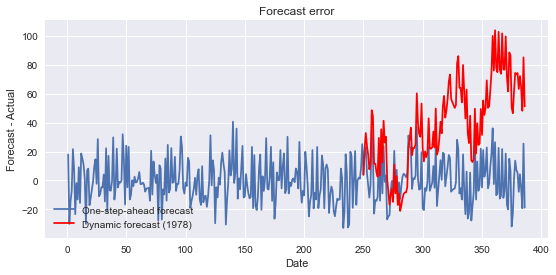

<IPython.core.display.Javascript object>

In [90]:
# Prediction error

# Graph
fig, ax = plt.subplots(figsize=(9, 4))
npre = 4
ax.set(title="Forecast error", xlabel="Date", ylabel="Forecast - Actual")

# In-sample one-step-ahead predictions and 95% confidence intervals
predict_error = predict.predicted_mean - df.Close
predict_error.loc[1:].plot(ax=ax, label="One-step-ahead forecast")

# Dynamic predictions and 95% confidence intervals
predict_dy_error = predict_dy.predicted_mean - df.Close
predict_dy_error.loc[250:].plot(ax=ax, style="r", label="Dynamic forecast (1978)")

legend = ax.legend(loc="lower left")
legend.get_frame().set_facecolor("w")

### Train test split 

In [57]:
n = int(len(df) * 0.8)
train = df.close[:n]
test = df.close[n:]

<IPython.core.display.Javascript object>

In [58]:
print(len(train))
print(len(test))

1402
351


<IPython.core.display.Javascript object>

In [59]:
step = 30

model = ARIMA(train, order=(6, 1, 3))
result = model.fit(disp=0)

# Forecast
fc, se, conf = result.forecast(step)

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


<IPython.core.display.Javascript object>

In [60]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

NameError: name 'fc' is not defined

<IPython.core.display.Javascript object>

NameError: name 'fc' is not defined

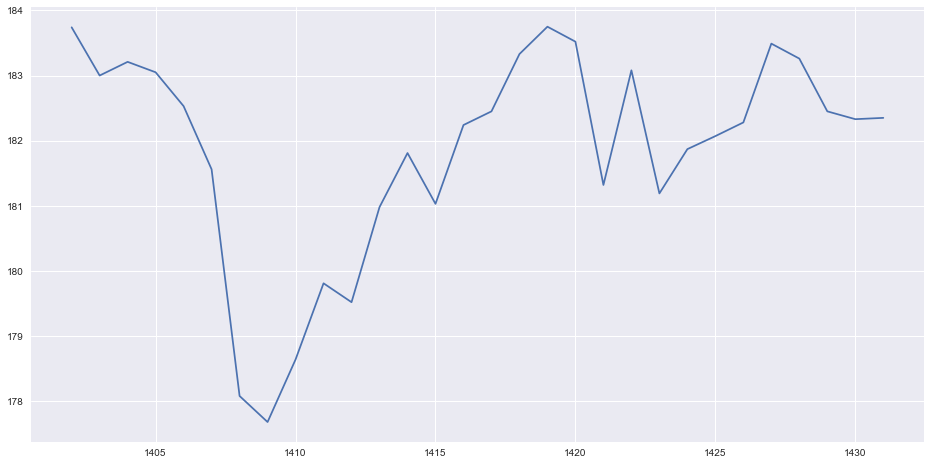

<IPython.core.display.Javascript object>

In [61]:
plt.figure(figsize=(16, 8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")

### Auto ARIMA

The pmdarima package provides an auto_arima method that uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [8]:
from pmdarima.arima import auto_arima

<IPython.core.display.Javascript object>

In [18]:
model = auto_arima(df.Close, trace=True, information_criterion="aic")
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3196.617, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3310.156, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3233.841, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3193.525, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3308.156, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3195.498, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3195.492, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3195.923, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3191.538, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3193.510, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3193.504, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3231.842, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3193.936, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.850 seconds
                      

<IPython.core.display.Javascript object>